Import 

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import KFold

from numpy.random import randint, randn, shuffle
from time import time
from scipy.stats import norm
from sklearn.utils import resample

Define Franke function

In [2]:
def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4

Create design matrix for for two dimensions

In [3]:
def create_X(x, y, n):
    #n is the order of the polynomial, in this project it will be 5
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    N = len(x)
    p = int((n+1)*(n+2)/2)  #Number of elements in beta, 
    X = np.ones((N, p))
    
    for i in range(1,n+1):
        q = int(i*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    
    return X

Define R2 score function

In [4]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

Define Mean Squared Error (MSE) function

In [5]:
def MSE(y_data,y_model):
    return np.sum((y_data-y_model)**2)/len(y_data)

Make design matrix

Normal distributed noise is added to the Franke-function 

In [6]:
n = 100 #size of x and y
N = 5 #polynomial degree
noise_factor = 0.01

x = np.random.uniform(0,1,n)
y = np.random.uniform(0,1,n)
noise = noise_factor*np.random.randn(100,1)
z = FrankeFunction(x,y) + noise

X = create_X(x, y, N)

DesignMatrix = pd.DataFrame(X)
#display(DesignMatrix)

Perform the Ordinary Least Square (OLS) method and print the MSE and R2 results

In [7]:
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train

z_tilde = X_train @ beta
z_predict = X_test @ beta

print("Training R2")
print(R2(z_train,z_tilde))
print(' ')
print("Training MSE")
print(MSE(z_train,z_tilde))
print(' ')
print("Test R2")
print(R2(z_test,z_predict))
print(' ')
print("Test MSE")
print(MSE(z_test,z_predict))

Training R2
0.99903669733066
 
Training MSE
0.007797820797984548
 
Test R2
0.9977413398898903
 
Test MSE
0.018281148482861127


Study the bias-variance trade-off by plotting the MSE for increasing model complexity (i.e. the number of polynomials)

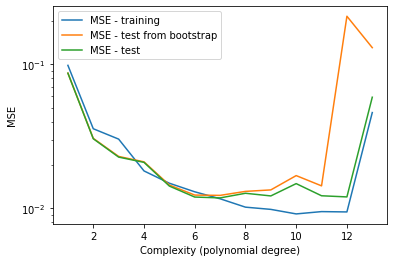

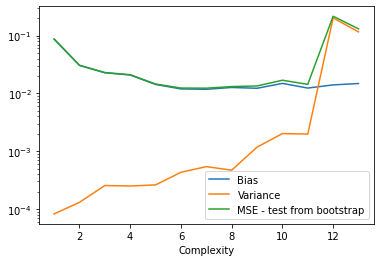

In [23]:
np.random.seed(47309275)
max_degree = 13
n = 1000
noise_factor = .1
n_bootstraps = 100

degree = np.linspace(1, max_degree, max_degree)
MSE_test = np.zeros(max_degree)
MSE_train = np.zeros(max_degree)
MSE_test_bootstrap = np.zeros(max_degree)

bias = np.zeros(max_degree)
variance = np.zeros(max_degree)
error = np.zeros(max_degree)

noise = noise_factor*np.random.randn(n)
x = np.random.uniform(0,1,n)
y = np.random.uniform(0,1,n)

z = FrankeFunction(x,y) + noise

for i in range(max_degree):
    N = i #polynomial degree
    X = create_X(x, y, N)
    
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)

    scaler = StandardScaler(with_mean = True, with_std = False)
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #Perform regular OLS
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
    z_tilde = X_train @ beta
    z_predict = X_test @ beta
    MSE_train[i] = MSE(z_train,z_tilde)
    MSE_test[i] = MSE(z_test,z_predict)
    
    #Perform OLS with bootstrap resampling
    MSE_test_bootstrap_values = np.zeros(n_bootstraps)
    z_predicted_bootstrap = np.empty((X_test.shape[0], n_bootstraps))
    
    
    for j in range(n_bootstraps):
        X_train_resample, z_train_resample = resample(X_train, z_train, replace=True)
        beta = np.linalg.inv(X_train_resample.T @ X_train_resample) @ X_train_resample.T @ z_train_resample
        z_predicted_bootstrap[:, j] = X_test @ beta
        MSE_test_bootstrap_values[j] = MSE(z_test, z_predicted_bootstrap[:, j]) 
    
    MSE_test_bootstrap[i] = np.mean(MSE_test_bootstrap_values)
    
    bias[i] = np.mean( (z_test - np.mean(z_predicted_bootstrap, axis=1))**2 )
    variance[i] = np.mean(np.var(z_predicted_bootstrap, axis=1))
    
plt.figure()
plt.ylabel('MSE')
plt.xlabel('Complexity (polynomial degree)')
plt.plot(degree, MSE_train, label='MSE - training') 
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap') 
plt.plot(degree, MSE_test, label='MSE - test')
plt.yscale('log')
plt.legend()
plt.savefig('figures/mse_test_training_bootstrap')
plt.show()

plt.figure()
plt.xlabel('Complexity')
plt.plot(degree, bias, label='Bias')
plt.plot(degree, variance, label='Variance')
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap')
plt.yscale('log')
plt.legend()
plt.savefig('figures/bias_variande_tradeoff_bootstrap')
plt.show()

Implement k-fold cross validation

0.09627123419413229

0.09627123419413229

0.0

0.0351259605996767

0.0351259605996767

0.0

0.029344051505602486

0.029344051505602486

0.0

0.019210197104157105

0.019210197104157105

0.0

0.015164573709089016

0.015164573709089016

0.0

0.013401262404608632

0.013401262404608632

0.0

0.012490972285852192

0.012490972285852192

0.0

0.01160141488126016

0.01160141488126016

0.0

0.01140368153680601

0.01140368153680601

0.0

0.01162008046740607

0.01162008046740607

0.0

0.01204793086519725

0.01204793086519725

0.0

0.01356797175334517

0.01356797175334517

0.0

0.05493473026171665

0.05493473026171665

0.0

/Users/tellefs/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


0.09642017868218275

0.09642017868218275

0.0

0.03496811276131307

0.03496811276131307

0.0

0.029119377271794

0.029119377271794

0.0

0.01906891691575836

0.01906891691575836

0.0

0.015143885842918444

0.015143885842918444

0.0

0.013380616688822828

0.013380616688822828

0.0

0.012414969098335173

0.012414969098335173

0.0

0.01147014002114853

0.01147014002114853

0.0

0.011322681758433267

0.011322681758433267

0.0

0.011491984339982048

0.011491984339982048

0.0

0.011812134118356247

0.011812134118356247

0.0

0.012720813434574445

0.012720813434574445

0.0

0.1086065502010662

0.1086065502010662

0.0

0.09630524455725348

0.09630524455725348

0.0

0.03496175011948244

0.03496175011948244

0.0

0.02917255546553136

0.02917255546553136

0.0

0.019109086236328

0.019109086236328

0.0

0.015246144791684266

0.015246144791684266

0.0

0.013446533052363716

0.013446533052363716

0.0

0.012518669489466954

0.012518669489466954

0.0

0.011508993137110101

0.011508993137110101

0.0

0.011291820533491679

0.011291820533491679

0.0

0.011539490383434964

0.011539490383434964

0.0

0.011742550326413241

0.011742550326413241

0.0

0.06973495147969501

0.06973495147969501

0.0

0.2603343563999624

0.2603343563999624

0.0

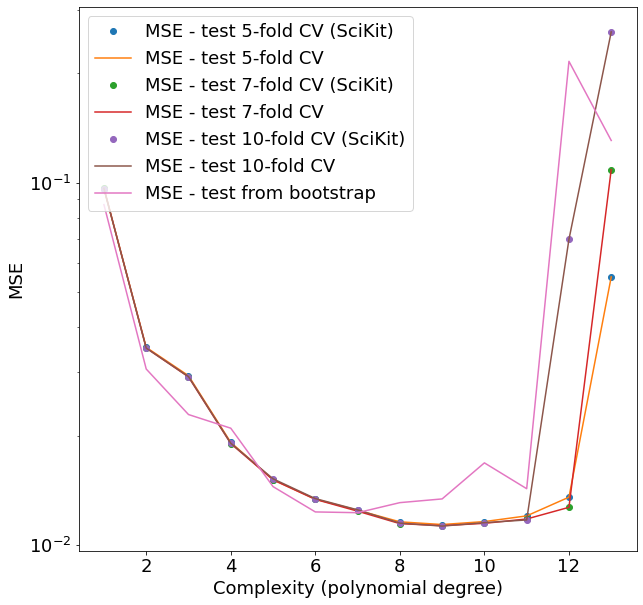

In [45]:
np.random.seed(47309275)

folds = np.array([5, 7, 10]) #number of folds

degree = np.linspace(1, max_degree, max_degree)

fig, ax = plt.subplots(figsize=(10, 10))

for k_folds in folds:
    
    MSE_test_kfold = np.zeros(max_degree)
    MSE_test_kfold_scikit = np.zeros(max_degree)
    
    for i in range(max_degree):
        
        X = create_X(x, y, i)
        
        #k-fold cross validation
        z_split = np.array_split(z, k_folds)
        X_split = np.array_split(X, k_folds)
        MSE_test_kfold_values = np.zeros(k_folds)

        for k in range(k_folds):
            
            z_test = z_split[k]
            z_train = np.concatenate(np.delete(z_split, k, 0))

            X_test = X_split[k] #picks out the kth matrix from X
            X_train = np.concatenate(np.delete(X_split, k, 0)) #deletes the kth matrix, and leaves the rest
            beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
            z_predict = X_test @ beta
            MSE_test_kfold_values[k] = MSE(z_test,z_predict)
            
        MSE_test_kfold[i] = np.mean(MSE_test_kfold_values)
        display(MSE_test_kfold[i])
        
        #k-fold cross validation using SciKit    
        kfold_scikit = KFold(n_splits = k_folds)
        MSE_test_kfold_values_scikit = np.zeros(k_folds)
        
        k=0
        for train_inds, test_inds in kfold_scikit.split(X):
            
            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]
            
            beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
            z_predict = X_test @ beta
            MSE_test_kfold_values_scikit[k] = MSE(z_test,z_predict)
            k+=1
        
        MSE_test_kfold_scikit[i] = np.mean(MSE_test_kfold_values_scikit)
        display(MSE_test_kfold_scikit[i])
        display(MSE_test_kfold_scikit[i]-MSE_test_kfold[i])

    ax.plot(degree, MSE_test_kfold_scikit, 'o', label='MSE - test %.i-fold CV (SciKit)'%k_folds)   
    ax.plot(degree, MSE_test_kfold, label='MSE - test %.i-fold CV'%k_folds)


plt.ylabel('MSE', fontsize=18)
plt.xlabel('Complexity (polynomial degree)', fontsize=18)
#plt.plot(degree, MSE_train, label='MSE - training') 
ax.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap')
#plt.plot(degree, MSE_test, label='MSE - test')
plt.yscale('log')
ax.tick_params(axis='both', which='both', labelsize=18)
ax.legend(fontsize=18, loc='upper left')
plt.savefig('figures/mse_test_training_bootstrap')
plt.show()

Implement Ridge Regression on Franke data

Implement Lasso regression on Franke data

Prepare real data for analysis

Apply all three regression methods to the real data with cross-validation as resampling